<a href="https://colab.research.google.com/github/MostafaNabieh/Data-augmentation/blob/master/Data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

manual image manipulations and augmentation using tf.image.

Data augmentation is a common technique to improve results and avoid overfitting, see Overfitting and Underfitting for others.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
import urllib
try :
  %tensorflow_version 2.x
except :
  pass
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_datasets as tfds
import PIL.Image 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)
import numpy as np

Let's check the data augmentation feautres on an image and then augment a whole dataset later to train a model.

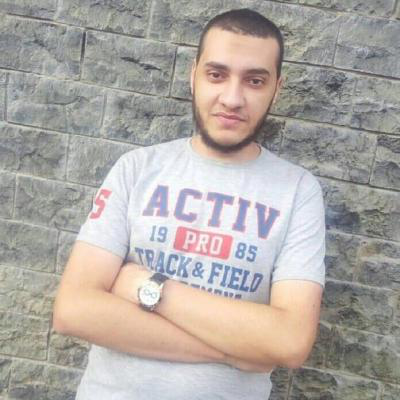

In [8]:
image_path=tf.keras.utils.get_file('Mostafa.jpg','https://raw.githubusercontent.com/MostafaNabieh/Data-augmentation/master/46414243.jpg')
PIL.Image.open(image_path)

Read and decode the image to tensor format.



In [0]:
image_string=tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string,channels=3)

A function to visualize and compare the original and augmented image side by side.



In [0]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

Augment a single image
Flipping the image
Flip the image either vertically or horizontally.

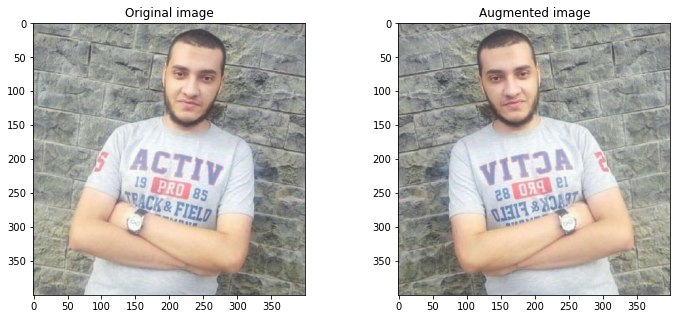

In [12]:
flipped =tf.image.flip_left_right(image)
visualize(image,flipped)

##Grayscale the image
Grayscale an image.

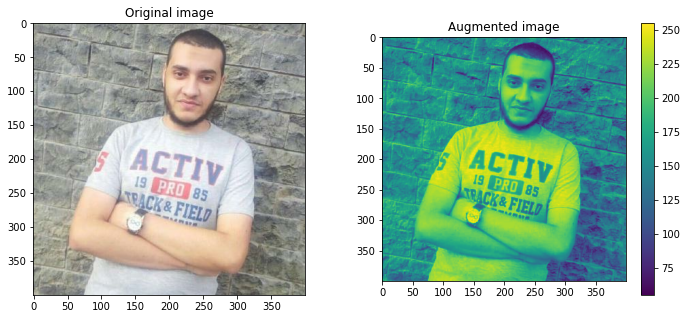

In [13]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

##Saturate the image
Saturate an image by providing a saturation factor.

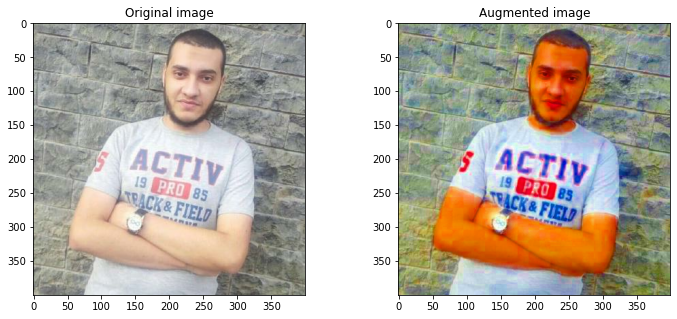

In [22]:
saturated = tf.image.adjust_saturation(image, 4)
visualize(image, saturated)

##Change image brightness
Change the brightness of image by providing a brightness factor.

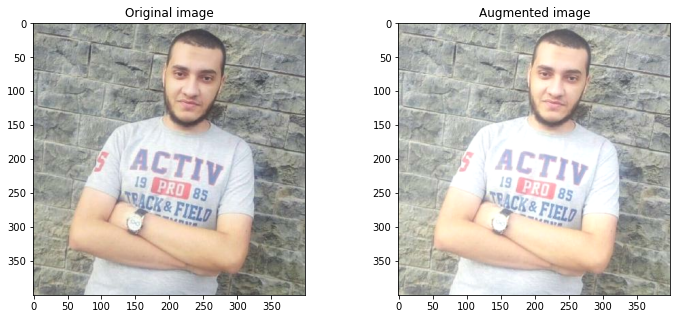

In [16]:
bright = tf.image.adjust_brightness(image, 0.1)
visualize(image, bright)

##Rotate the image
Rotate an image by 90 degrees.

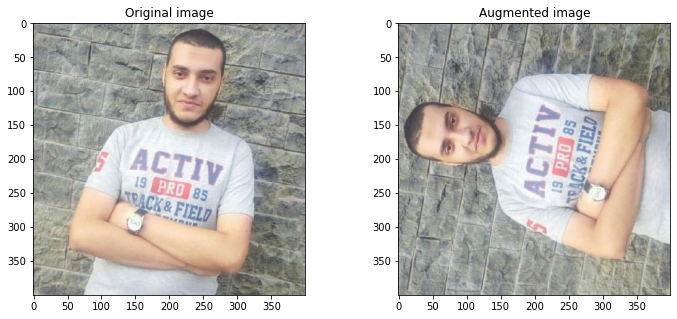

In [23]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

##Center crop the image
Crop the image from center upto the image part you desire.

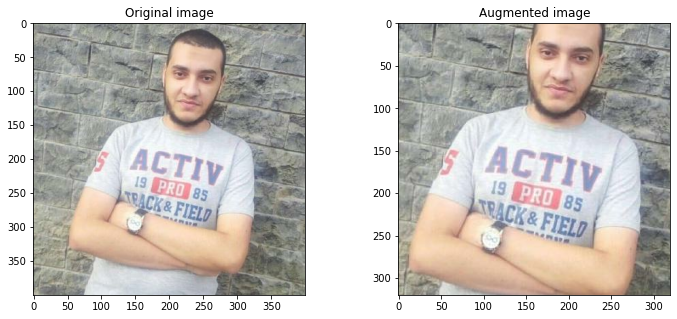

In [31]:
cropped = tf.image.central_crop(image, central_fraction=0.8)
visualize(image,cropped)

##Augment a dataset and train a model with it
Train a model on an augmented dataset.

In [32]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


Write a function to augment the images. Map it over the the dataset. This returns a dataset that augments the data on the fly.

In [0]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

  return image,label

In [0]:
BATCH_SIZE = 64
NUM_EXAMPLES = 2048

Create the augmented dataset.



In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

augmented_train_batches= (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

And a non-augmented one for comparison.



In [0]:
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

Setup the validation dataset. This doesn't change whether or not you're using the augmentation.



In [0]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

Create and compile the model. The model is a two layered, fully-connected neural network without convolution.



In [0]:
def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

Train the model, without augmentation:



In [43]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 3s 90ms/step - loss: 0.7233 - accuracy: 0.7749 - val_loss: 0.3967 - val_accuracy: 0.8820
Epoch 2/50
32/32 [==============================] - 2s 72ms/step - loss: 0.1803 - accuracy: 0.9463 - val_loss: 0.2973 - val_accuracy: 0.9088
Epoch 3/50
32/32 [==============================] - 2s 73ms/step - loss: 0.0711 - accuracy: 0.9771 - val_loss: 0.2924 - val_accuracy: 0.9239
Epoch 4/50
32/32 [==============================] - 2s 72ms/step - loss: 0.0520 - accuracy: 0.9849 - val_loss: 0.3159 - val_accuracy: 0.9212
Epoch 5/50
32/32 [==============================] - 3s 80ms/step - loss: 0.0377 - accuracy: 0.9912 - val_loss: 0.3165 - val_accuracy: 0.9240
Epoch 6/50
32/32 [==============================] - 2s 70ms/step - loss: 0.0120 - accuracy: 0.9971 - val_loss: 0.3029 - val_accuracy: 0.9322
Epoch 7/50
32/32 [==============================] - 3s 78ms/step - loss: 0.0092 - accuracy: 0.9976 - val_loss: 0.3403 - val_accuracy: 0.9305
Epoch 8/50
32

Train it again with augmentation:



In [44]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 3s 96ms/step - loss: 2.4519 - accuracy: 0.2744 - val_loss: 1.2870 - val_accuracy: 0.6514
Epoch 2/50
32/32 [==============================] - 2s 77ms/step - loss: 1.5101 - accuracy: 0.4888 - val_loss: 0.7814 - val_accuracy: 0.7781
Epoch 3/50
32/32 [==============================] - 2s 74ms/step - loss: 1.0731 - accuracy: 0.6309 - val_loss: 0.5793 - val_accuracy: 0.8241
Epoch 4/50
32/32 [==============================] - 3s 83ms/step - loss: 0.8078 - accuracy: 0.7280 - val_loss: 0.4788 - val_accuracy: 0.8498
Epoch 5/50
32/32 [==============================] - 2s 77ms/step - loss: 0.7421 - accuracy: 0.7549 - val_loss: 0.4211 - val_accuracy: 0.8771
Epoch 6/50
32/32 [==============================] - 3s 86ms/step - loss: 0.5874 - accuracy: 0.8042 - val_loss: 0.3577 - val_accuracy: 0.8908
Epoch 7/50
32/32 [==============================] - 2s 77ms/step - loss: 0.5239 - accuracy: 0.8267 - val_loss: 0.2769 - val_accuracy: 0.9189
Epoch 8/50
32

Conclusion:
augmented model converges to an accuracy ~95% on validation set. This is slightly higher (+1%) than the model trained without data augmentation.

(0.75, 1.0)

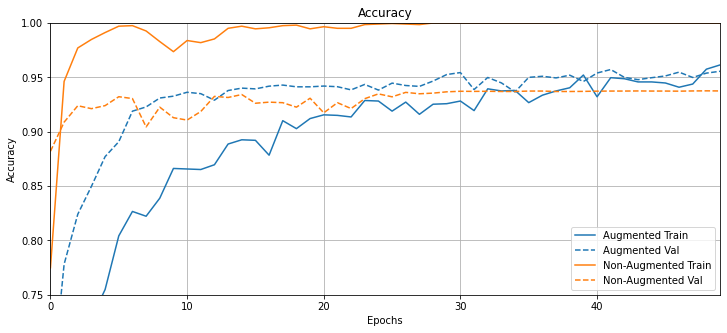

In [45]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75,1])

In terms of loss, the non-augmented model is obviously in the overfitting regime. The augmented model, while a few epoch slower, is still training correctly and clearly not overfitting

(0.0, 1.0)

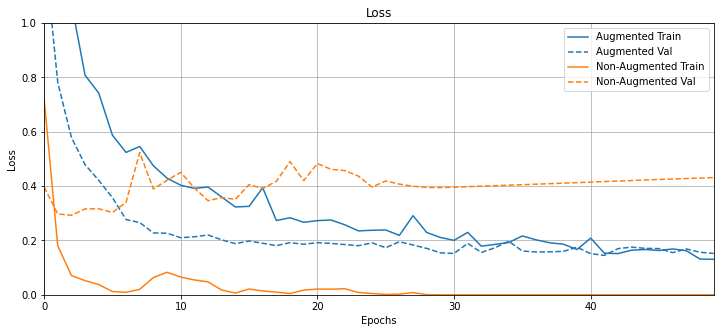

In [46]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])